In [1]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2023-05-02 18:17:50.740577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Pull in and explore data

In [5]:
df = read_csv('/Users/nikhilaiyer/Documents/GRAD SCHOOL/y2s2/[ANLY560] Time Series/final-project_data/sponsor-stocks.csv', usecols=[0,3], engine='python')
df.head()

,NKE,Dates
0,58.102970,2016-03-23
1,57.367851,2016-03-24
2,57.079372,2016-03-28
3,57.218956,2016-03-29
4,57.730747,2016-03-30


In [8]:
x = np.array(df["NKE"].values.astype('float32')).reshape(df.shape[0],1)
print(x)

[[ 58.10297 ]
 [ 57.36785 ]
 [ 57.079372]
 ...
 [104.63882 ]
 [105.92487 ]
 [109.35435 ]]


### Visualize

In [9]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.express as px

# UTILITY
def plotly_line_plot(t,y,title="Plot",x_label="t: time (days)",y_label="y(t): Response variable"):

    # GENERATE PLOTLY FIGURE
    fig = px.line(x=t[0],y=y[0], title=title, render_mode='SVG')  
    # IMPORTANT: SVG FIXES RENDER ISSUES WITH SAD FACE 
    # https://community.plotly.com/t/plotly-express-line-charts-are-not-shown/39715
    
    # ADD MORE
    for i in range(1,len(y)):
        if len(t[i])==1:
            #print(t[i],y[i])
            fig.add_scatter(x=t[i],y=y[i])
        else:
            fig.add_scatter(x=t[i],y=y[i], mode='lines')

    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white",
        showlegend=False
    )
    fig.show()


In [35]:
# SINGLE SERIES 
t=[*range(0,len(x))]
plotly_line_plot([t],[x[:,0]],title="Nike Stock Data from 2016")

### Train-Test Split

In [12]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

train_data, test_data, data = get_train_test(x)

print(train_data.shape)
print(test_data.shape)

(1348,)
(338,)


In [34]:
# SINGLE SERIES 
t1=[*range(0,len(train_data))]
t2=len(train_data)+np.array([*range(0,len(test_data))])
plotly_line_plot([t1,t2],[train_data,test_data],title="Train Test Split on Nike Stock Price Data")

### Reformat for Keras

In [14]:
# PREPARE THE INPUT X AND TARGET Y
def get_XY(dat, time_steps,plot_data_partition=False):
    global X_ind,X,Y_ind,Y #use for plotting later

    # INDICES OF TARGET ARRAY
    # Y_ind [  12   24   36   48 ..]; print(np.arange(1,12,1)); exit()
    Y_ind = np.arange(time_steps, len(dat), time_steps); #print(Y_ind); exit()
    Y = dat[Y_ind]

    # PREPARE X
    rows_x = len(Y)
    X_ind=[*range(time_steps*rows_x)]
    del X_ind[::time_steps] #if time_steps=10 remove every 10th entry
    X = dat[X_ind]; 

    #PLOT
    if(plot_data_partition):
        plt.figure(figsize=(15, 6), dpi=80)
        plt.plot(Y_ind, Y,'o',X_ind, X,'-'); plt.show(); 

    #RESHAPE INTO KERAS FORMAT
    X1 = np.reshape(X, (rows_x, time_steps-1, 1))
    # print([*X_ind]); print(X1); print(X1.shape,Y.shape); exit()

    return X1, Y


#PARTITION DATA
p=10 # simpilar to AR(p) given time_steps data points, predict time_steps+1 point (make prediction one month in future)

testX, testY = get_XY(test_data, p)
trainX, trainY = get_XY(train_data, p)

In [15]:
print(testX.shape,testY.shape)
print(trainX.shape,trainY.shape)
print(type(trainX))

(33, 9, 1) (33,)
(134, 9, 1) (134,)
<class 'numpy.ndarray'>


In [16]:
## Build list 
tmp1=[]; tmp2=[]; tmp3=[]; count=0
for i in range(0,trainX.shape[0]):
    # tmp1.append()
    tmp1.append(count+np.array([*range(0,trainX[i,:,0].shape[0])]))
    tmp1.append([count+trainX[i,:,0].shape[0]]); #print(([count+trainX[i,:,0].shape[0]]))
    # tmp1.append([count+trainX[i,:,0].shape[0]+1])
    tmp2.append(trainX[i,:,0])
    tmp2.append([trainY[i]]); #print([trainY[i]])
    # tmp2.append([trainY[i]])

    count+=trainX[i,:,0].shape[0]+1

    # print(i,trainX[i,:,0].shape)
# print(tmp1)
# print(tmp2)
plotly_line_plot(tmp1,tmp2,title="Sunspots per month since 1749-01")

### Model Training and Parameters

In [17]:
#USER PARAM
recurrent_hidden_units=3
epochs=60
f_batch=0.2    #fraction used for batch size
optimizer="RMSprop"
validation_split=0.2
print(trainX.shape,p,trainY.shape)

# trainY=trainY.reshape(trainY.shape[0],1)
# testY=testY.reshape(testY.shape[0],1)
print(p,trainX.shape,testX.shape,trainY.shape,testY.shape)

(134, 9, 1) 10 (134,)
10 (134, 9, 1) (33, 9, 1) (134,) (33,)


### Create Model

In [57]:
from tensorflow.keras import regularizers


#CREATE MODEL
model = Sequential()
#COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(SimpleRNN(
model.add(GRU(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(1e-1),
activation='tanh')
          ) 
     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# COMPILE THE MODEL 
model.compile(loss='MeanSquaredError', optimizer=optimizer)
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 3)                 54        
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


2023-05-02 20:19:43.118126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 20:19:43.121467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 20:19:43.122900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Train Model

In [58]:
#TRAIN MODEL
history = model.fit(
trainX, trainY, 
epochs=epochs, 
batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)

Epoch 1/60


2023-05-02 20:19:46.220717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 20:19:46.221859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 20:19:46.223921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 - 2s - loss: 0.2974 - val_loss: 0.3135 - 2s/epoch - 396ms/step
Epoch 2/60


2023-05-02 20:19:47.879524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 20:19:47.881392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 20:19:47.882852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 - 0s - loss: 0.2839 - val_loss: 0.3011 - 58ms/epoch - 12ms/step
Epoch 3/60
5/5 - 0s - loss: 0.2753 - val_loss: 0.2874 - 50ms/epoch - 10ms/step
Epoch 4/60
5/5 - 0s - loss: 0.2679 - val_loss: 0.2810 - 56ms/epoch - 11ms/step
Epoch 5/60
5/5 - 0s - loss: 0.2611 - val_loss: 0.2732 - 65ms/epoch - 13ms/step
Epoch 6/60
5/5 - 0s - loss: 0.2546 - val_loss: 0.2634 - 80ms/epoch - 16ms/step
Epoch 7/60
5/5 - 0s - loss: 0.2484 - val_loss: 0.2587 - 65ms/epoch - 13ms/step
Epoch 8/60
5/5 - 0s - loss: 0.2423 - val_loss: 0.2499 - 71ms/epoch - 14ms/step
Epoch 9/60
5/5 - 0s - loss: 0.2364 - val_loss: 0.2444 - 51ms/epoch - 10ms/step
Epoch 10/60
5/5 - 0s - loss: 0.2306 - val_loss: 0.2373 - 55ms/epoch - 11ms/step
Epoch 11/60
5/5 - 0s - loss: 0.2249 - val_loss: 0.2312 - 49ms/epoch - 10ms/step
Epoch 12/60
5/5 - 0s - loss: 0.2194 - val_loss: 0.2230 - 54ms/epoch - 11ms/step
Epoch 13/60
5/5 - 0s - loss: 0.2139 - val_loss: 0.2194 - 54ms/epoch - 11ms/step
Epoch 14/60
5/5 - 0s - loss: 0.2086 - val_loss: 0.2108 - 60

### Visualize Fitting History

2/2 [==============================] - 0s 3ms/step
(134, 9, 1) (134,) (134,) (33, 9, 1) (33,) (33,)
(134,) (134,)
0.032503888
0.11077585
Train MSE = 0.03250 RMSE = 0.18029
Test MSE = 0.11078 RMSE = 0.33283


[0.4475483298301697, 0.4230097234249115, 0.40622785687446594, 0.3943394124507904, 0.3850599527359009, 0.3771184980869293, 0.3677455484867096, 0.3619535267353058, 0.3549095690250397, 0.3485848903656006, 0.34282535314559937, 0.3372514247894287, 0.3318512737751007, 0.32735854387283325, 0.3231528103351593, 0.31879931688308716, 0.3146559000015259, 0.3101583421230316, 0.3055610954761505, 0.3009767532348633, 0.2967640459537506, 0.2926393151283264, 0.28812897205352783, 0.2837844491004944, 0.2793785035610199, 0.27526378631591797, 0.2709333002567291, 0.26666268706321716, 0.2623412311077118, 0.2580311894416809, 0.25406989455223083, 0.249619722366333, 0.24565963447093964, 0.2412959635257721, 0.236832395195961, 0.23255671560764313, 0.2283826470375061, 0.22408176958560944, 0.2197583168745041, 0.21538153290748596, 0.21092016994953156, 0.20654557645320892, 0.20202329754829407, 0.19758017361164093, 0.19313523173332214, 0.18881110846996307, 0.18455320596694946, 0.18022456765174866, 0.1759718954563141, 0

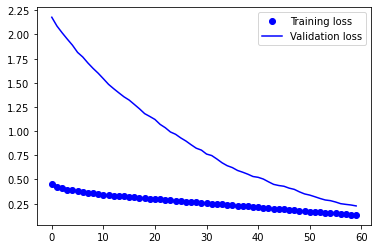

In [56]:
#HISTORY PLOT
epochs_steps = [*range(0, len(history.history['loss']))]

# MAKE PREDICTIONS
train_predict = model.predict(trainX).squeeze()
test_predict = model.predict(testX).squeeze()
print(trainX.shape, train_predict.shape,trainY.shape,testX.shape, test_predict.shape,testY.shape)

#COMPUTE RMSE
print(trainY.shape, train_predict.shape)
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))
print(np.mean((trainY-train_predict)**2.0))
print(np.mean((testY-test_predict)**2.0))

print('Train MSE = %.5f RMSE = %.5f' % (train_rmse**2.0,train_rmse))
print('Test MSE = %.5f RMSE = %.5f' % (test_rmse**2.0,test_rmse))    

# PLOTLY PLOT
plotly_line_plot([epochs_steps,epochs_steps],[history.history['loss'],history.history['val_loss']],title="GRU: Nike Stock Data Since 2016",x_label="training epochs",y_label="loss (MSE)")

print(history.history['loss'])
# SIMPLE PLOT 
plt.figure()
plt.plot(epochs_steps, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs_steps, history.history['val_loss'], 'b', label='Validation loss')
plt.legend()

### Visualize Parity Plot

In [55]:
# GET DATA
# GENERATE PLOTLY FIGURE

fig = px.scatter(x=trainY,y=train_predict,height=600,width=800)
fig.add_scatter(x=testY,y=test_predict,mode="markers")
fig.add_scatter(x=trainY,y=trainY, mode='lines')

fig.update_layout(
    title='RNN: Parity Plot of Nike Stock Data Since 2016',
    xaxis_title="y_pred",
    yaxis_title="y_data",
    template="plotly_white",
    showlegend=False
)

fig.show()

(1206,) (134,)


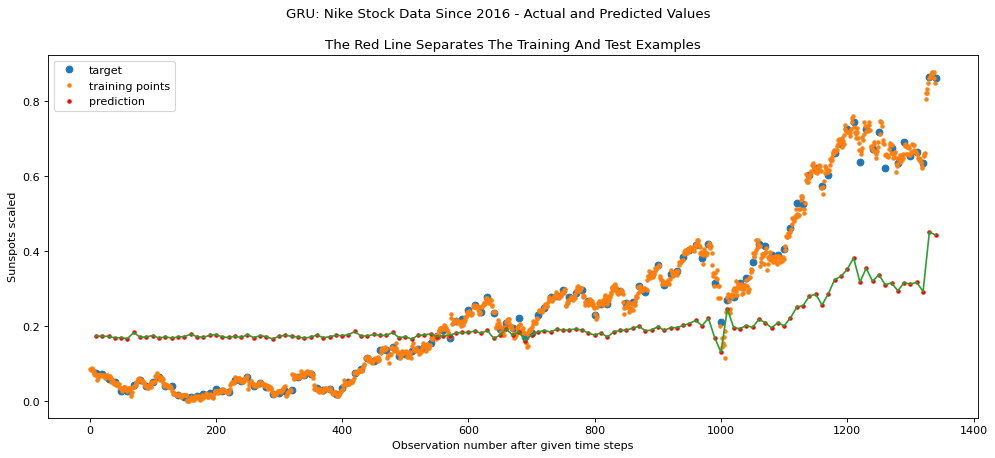

In [59]:
# PLOT THE RESULT
def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=80)
    #ORIGINAL DATA
    print(X.shape,Y.shape)
    plt.plot(Y_ind, Y,'o', label='target')
    plt.plot(X_ind, X,'.', label='training points');     
    plt.plot(Y_ind, train_predict,'r.', label='prediction');    
    plt.plot(Y_ind, train_predict,'-');    
    plt.legend()
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.suptitle('GRU: Nike Stock Data Since 2016 - Actual and Predicted Values')
    plt.title('The Red Line Separates The Training And Test Examples')
    plt.show()
plot_result(trainY, testY, train_predict, test_predict)